In [23]:
import os

project_dir = '/content/drive/MyDrive/AI+X:딥러닝/ValidFixWorld'

# 해당 경로로 작업 위치 이동
try:
    os.chdir(project_dir)
    print(f"작업 디렉토리가 성공적으로 변경되었습니다: {os.getcwd()}")
except FileNotFoundError:
    print(f"경로를 찾을 수 없습니다. 경로를 확인해주세요: {project_dir}")

# 주의: 이제 코드는 위 폴더에서 'ratings_train.txt'를 찾습니다.
# 데이터 파일들도 위 구글 드라이브 폴더 안에 들어있어야 합니다.

작업 디렉토리가 성공적으로 변경되었습니다: /content/drive/MyDrive/AI+X:딥러닝/ValidFixWorld


### 1. 프로젝트 개요 및 환경 설정

본 프로젝트는 NSMC(Naver Sentiment Movie Corpus) 데이터셋을 활용하여 한국어 텍스트의 감성을 분류하는 다양한 모델링 방법론을 비교 분석합니다. 통계 기반 머신러닝(TF-IDF, Word2Vec, Decision Tree)부터 딥러닝(CNN, LSTM)까지 단계적으로 적용하며, 특히 전처리 수준(Raw, Morpheme, Jamo)이 성능에 미치는 영향을 규명합니다.

**참여자 정보**
*   정보시스템학과 2024062042 김규민
*   정보시스템학과 2023092606 송정빈

**실험 환경**
*   플랫폼: Google Colab (GPU T4)
*   Python: 3.12.12 호환
*   데이터: `ratings_train.txt`, `ratings_test.txt` (현재 디렉토리에 위치 가정)

In [24]:
# 1. Mecab 설치 (C++ 기반의 고속 형태소 분석기 python-mecab-ko)
!pip install python-mecab-ko

# 2. 공통 라이브러리 및 자소 분리 패키지 설치
!pip install jamo gensim torch scikit-learn pandas numpy matplotlib seaborn tqdm

### 2. 라이브러리 임포트 및 시드 고정

실험에 필요한 라이브러리를 import하고, 재현성을 위해 Seed를 고정합니다.


In [25]:
import os
import re
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from mecab import MeCab
from jamo import h2j, j2hcj
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


### 3. 데이터 로드 및 전처리 파이프라인

전처리 파이프라인 상세 계획에 따라 3가지 전략을 구현합니다.
*   **Pipeline A (Raw):** 띄어쓰기 기준 분절.
*   **Pipeline B (Morpheme):** Mecab 형태소 분석 + 불용어 제거.
*   **Pipeline C (Jamo):** 자소 단위 분해.

처리된 데이터는 `pickle`로 캐싱하여 재실행 시 시간을 단축합니다.


In [26]:
# 불용어 리스트 (예시)
STOPWORDS = set(['은', '는', '이', '가', '을', '를', '의', '에', '와', '과', '도', '으로', '만', '하다'])

def clean_text(text):
    if pd.isna(text): return ""
    # 한글, 영어, 숫자, 공백 제외 제거
    text = re.sub(r'[^ㄱ-ㅎ가-힣0-9a-zA-Z ]', '', str(text))
    return text.strip()

class Preprocessor:
    def __init__(self):
        self.mecab = MeCab()

    def process(self, text, method='raw'):
        text = clean_text(text)
        if not text: return []

        if method == 'raw':
            # Pipeline A: Whitespace tokenization
            return text.split()

        elif method == 'morpheme':
            # Pipeline B: Mecab morphs + Stopwords filter
            morphs = self.mecab.morphs(text)
            return [m for m in morphs if m not in STOPWORDS and len(m) > 1]

        elif method == 'jamo':
            # Pipeline C: Jamo decomposition
            # 예: "영화" -> "ㅇㅕㅇㅎㅘ" (List of characters)
            jamo_str = j2hcj(h2j(text))
            return list(jamo_str) # 문자 단위로 리스트화

def load_and_preprocess(file_path, method, cache_name):
    if os.path.exists(cache_name):
        print(f"Loading cached data: {cache_name}")
        with open(cache_name, 'rb') as f:
            return pickle.load(f)

    print(f"Processing data ({method}): {file_path}")
    df = pd.read_csv(file_path, sep='\t')
    preprocessor = Preprocessor()

    # 데이터 추출
    documents = df['document'].tolist()
    labels = df['label'].tolist()

    # 전처리 수행
    tokens_list = []
    valid_labels = []

    for doc, label in tqdm(zip(documents, labels), total=len(documents)):
        tokens = preprocessor.process(doc, method)
        if tokens: # 빈 데이터 제외
            tokens_list.append(tokens)
            valid_labels.append(label)

    data = {'tokens': tokens_list, 'labels': valid_labels}
    with open(cache_name, 'wb') as f:
        pickle.dump(data, f)
    return data

# 데이터셋 로드 (학습/테스트)
# 1. Raw Data (Pipeline A)
train_raw = load_and_preprocess('ratings_train.txt', 'raw', 'train_raw.pkl')
test_raw = load_and_preprocess('ratings_test.txt', 'raw', 'test_raw.pkl')

# 2. Morpheme Data (Pipeline B)
train_morphs = load_and_preprocess('ratings_train.txt', 'morpheme', 'train_morphs.pkl')
test_morphs = load_and_preprocess('ratings_test.txt', 'morpheme', 'test_morphs.pkl')

# 3. Jamo Data (Pipeline C) - 딥러닝 전용
train_jamo = load_and_preprocess('ratings_train.txt', 'jamo', 'train_jamo.pkl')
test_jamo = load_and_preprocess('ratings_test.txt', 'jamo', 'test_jamo.pkl')

Processing data (raw): ratings_train.txt


100%|██████████| 150000/150000 [00:00<00:00, 295154.16it/s]


Processing data (raw): ratings_test.txt


100%|██████████| 50000/50000 [00:00<00:00, 318800.41it/s]


Processing data (morpheme): ratings_train.txt


100%|██████████| 150000/150000 [00:29<00:00, 5011.86it/s]


Processing data (morpheme): ratings_test.txt


100%|██████████| 50000/50000 [00:09<00:00, 5287.31it/s]


Processing data (jamo): ratings_train.txt


100%|██████████| 150000/150000 [00:25<00:00, 5834.65it/s]


Processing data (jamo): ratings_test.txt


100%|██████████| 50000/50000 [00:07<00:00, 6259.98it/s]


### 4. 통계 기반 머신러닝 (Baseline)

사전에 설정했던 기본적인 머신러닝 기반 모델들을 통해 베이스라인 성능을 측정합니다.
*   **3.1 TF-IDF:** 단어 빈도 가중치 활용 + 로지스틱 회귀.
*   **3.2 Word2Vec:** 단어 임베딩 평균(Mean Pooling) + 로지스틱 회귀.
*   **3.3 Decision Tree:** TF-IDF 특성 + 결정 트리 분류기.


In [27]:
def save_prediction(model_name, preds):
    with open(f'prediction_{model_name}.txt', 'w') as f:
        for p in preds:
            f.write(f"{int(p)}\n")
    print(f"Saved: prediction_{model_name}.txt")

# 공통 데이터 분할 함수
def split_train_valid(data_dict):
    tokens = data_dict['tokens']
    labels = data_dict['labels']
    # stratify를 사용하여 라벨 비율 유지하며 8:2 분할
    t_tokens, v_tokens, t_labels, v_labels = train_test_split(
        tokens, labels, test_size=0.2, random_state=42, stratify=labels
    )
    return (t_tokens, t_labels), (v_tokens, v_labels)

# 3.1 TF-IDF Modeling
def exp_tfidf(train_data, test_data, exp_name):
    print(f"\n=== Running {exp_name} (TF-IDF) ===")
    (t_tokens, t_labels), (v_tokens, v_labels) = split_train_valid(train_data)

    # 데이터 준비
    X_train = [" ".join(t) for t in t_tokens]
    X_valid = [" ".join(t) for t in v_tokens]
    X_test = [" ".join(t) for t in test_data['tokens']]

    vectorizer = TfidfVectorizer(min_df=5, max_features=10000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_valid_vec = vectorizer.transform(X_valid) # 검증용
    X_test_vec = vectorizer.transform(X_test)   # 최종 테스트용

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_vec, t_labels)

    # 검증 성능 확인
    val_acc = accuracy_score(v_labels, model.predict(X_valid_vec))
    print(f"Validation Accuracy: {val_acc:.4f}")

    # 최종 테스트 예측
    preds = model.predict(X_test_vec)
    acc = accuracy_score(test_data['labels'], preds)
    print(f"Test Accuracy: {acc:.4f}")
    save_prediction(exp_name, preds)

# 3.2 Word2Vec Modeling
def exp_word2vec(train_data, test_data, exp_name):
    print(f"\n=== Running {exp_name} (Word2Vec) ===")
    (t_tokens, t_labels), (v_tokens, v_labels) = split_train_valid(train_data)

    # 전체 코퍼스로 W2V 학습 (Data Leakage 방지를 위해 t_tokens만 사용 권장되나, 임베딩 품질 위해 전체 사용하기도 함. 여기선 t_tokens만 사용)
    w2v_model = Word2Vec(sentences=t_tokens, vector_size=100, window=5, min_count=5, workers=4)

    def get_doc_vector(tokens, model):
        vecs = [model.wv[t] for t in tokens if t in model.wv]
        if len(vecs) > 0: return np.mean(vecs, axis=0)
        return np.zeros(model.vector_size)

    X_train = np.array([get_doc_vector(t, w2v_model) for t in t_tokens])
    X_valid = np.array([get_doc_vector(t, w2v_model) for t in v_tokens])
    X_test = np.array([get_doc_vector(t, w2v_model) for t in test_data['tokens']])

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, t_labels)

    val_acc = accuracy_score(v_labels, model.predict(X_valid))
    print(f"Validation Accuracy: {val_acc:.4f}")

    preds = model.predict(X_test)
    acc = accuracy_score(test_data['labels'], preds)
    print(f"Test Accuracy: {acc:.4f}")
    save_prediction(exp_name, preds)

# 3.3 Decision Tree Modeling
def exp_decision_tree(train_data, test_data, exp_name):
    print(f"\n=== Running {exp_name} (Decision Tree) ===")
    (t_tokens, t_labels), (v_tokens, v_labels) = split_train_valid(train_data)

    X_train = [" ".join(t) for t in t_tokens]
    X_valid = [" ".join(t) for t in v_tokens]
    X_test = [" ".join(t) for t in test_data['tokens']]

    vectorizer = TfidfVectorizer(min_df=5, max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_valid_vec = vectorizer.transform(X_valid)
    X_test_vec = vectorizer.transform(X_test)

    model = DecisionTreeClassifier(max_depth=20, random_state=42)
    model.fit(X_train_vec, t_labels)

    val_acc = accuracy_score(v_labels, model.predict(X_valid_vec))
    print(f"Validation Accuracy: {val_acc:.4f}")

    preds = model.predict(X_test_vec)
    acc = accuracy_score(test_data['labels'], preds)
    print(f"Test Accuracy: {acc:.4f}")
    save_prediction(exp_name, preds)

# 실험 실행
exp_tfidf(train_raw, test_raw, "TFIDF_Raw")         # Exp 1-1
exp_tfidf(train_morphs, test_morphs, "TFIDF_Pre")   # Exp 1-2
exp_word2vec(train_raw, test_raw, "W2V_Raw")        # Exp 2-1
exp_word2vec(train_morphs, test_morphs, "W2V_Pre")  # Exp 2-2
exp_decision_tree(train_raw, test_raw, "DT_Raw")    # Exp 3-1
exp_decision_tree(train_morphs, test_morphs, "DT_Pre") # Exp 3-2


=== Running TFIDF_Raw (TF-IDF) ===
Validation Accuracy: 0.7808
Test Accuracy: 0.7787
Saved: prediction_TFIDF_Raw.txt

=== Running TFIDF_Pre (TF-IDF) ===
Validation Accuracy: 0.8179
Test Accuracy: 0.8177
Saved: prediction_TFIDF_Pre.txt

=== Running W2V_Raw (Word2Vec) ===
Validation Accuracy: 0.7234
Test Accuracy: 0.7177
Saved: prediction_W2V_Raw.txt

=== Running W2V_Pre (Word2Vec) ===
Validation Accuracy: 0.7832
Test Accuracy: 0.7838
Saved: prediction_W2V_Pre.txt

=== Running DT_Raw (Decision Tree) ===
Validation Accuracy: 0.5654
Test Accuracy: 0.5587
Saved: prediction_DT_Raw.txt

=== Running DT_Pre (Decision Tree) ===
Validation Accuracy: 0.6574
Test Accuracy: 0.6590
Saved: prediction_DT_Pre.txt


### 5. 딥러닝 모델 준비 (Dataset & Vocabulary)

딥러닝 모델 학습을 위한 PyTorch Dataset 클래스와 단어장(Vocabulary) 구축 함수를 정의합니다.
*   **Special Tokens:** `<PAD>`: 0, `<UNK>`: 1
*   **Padding:** 배치 내 가변 길이를 처리하기 위해 패딩 적용.

In [28]:
class Vocab:
    def __init__(self, tokens_list, min_freq=2):
        self.token2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2token = {0: '<PAD>', 1: '<UNK>'}
        self.build_vocab(tokens_list, min_freq)

    def build_vocab(self, tokens_list, min_freq):
        freqs = {}
        for tokens in tokens_list:
            for token in tokens:
                freqs[token] = freqs.get(token, 0) + 1

        idx = 2
        for token, count in freqs.items():
            if count >= min_freq:
                self.token2idx[token] = idx
                self.idx2token[idx] = token
                idx += 1
        print(f"Vocab size: {len(self.token2idx)}")

    def encode(self, tokens):
        return [self.token2idx.get(t, 1) for t in tokens]

class NSMCDataset(Dataset):
    def __init__(self, data_dict, vocab, max_len=140):
        self.data = data_dict['tokens']
        self.labels = data_dict['labels']
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data[idx]
        label = self.labels[idx]
        indices = self.vocab.encode(tokens)
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.float)

def collate_fn(batch):

    sequences, labels = zip(*batch)

    lengths = [len(s) for s in sequences]
    # Pad sequences
    padded_seqs = torch.zeros(len(sequences), max(lengths), dtype=torch.long)
    for i, seq in enumerate(sequences):
        end = lengths[i]
        padded_seqs[i, :end] = torch.tensor(seq)[:end]

    return padded_seqs, torch.tensor(labels), lengths

### 6. 딥러닝 모델 아키텍처

두 가지 핵심 아키텍처를 구현합니다.
1.  **TextCNN (1D-CNN):** `Conv1d` -> `MaxPool` 구조. 형태소, 음절, 자소 단위 모델에서 공유합니다.
2.  **TextLSTM:** `LSTM`을 사용하여 문맥을 학습합니다. `pack_padded_sequence`를 사용해 효율성을 높입니다.

In [29]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=n_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths=None):
        # text: [batch size, sent len]
        embedded = self.embedding(text) # [batch size, sent len, emb dim]
        embedded = embedded.permute(0, 2, 1) # [batch size, emb dim, sent len]

        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # conved[n]: [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled[n]: [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.dropout(self.embedding(text))

        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

### 7. 학습 및 추론 루프

딥러닝 모델을 학습하고, 테스트 데이터에 대해 추론을 수행하여 결과를 파일로 저장하는 공통 함수입니다.

In [30]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0

        # tqdm을 사용하여 진행률(%) 표시
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for text, label, lengths in progress_bar:
            text, label = text.to(device), label.to(device)
            optimizer.zero_grad()
            predictions = model(text, lengths).squeeze(1)
            loss = criterion(predictions, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # 진행바 옆에 현재 Loss 표시 (선택사항)
            progress_bar.set_postfix({'loss': loss.item()})

        # Validation Phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for text, label, lengths in val_loader:
                text, label = text.to(device), label.to(device)
                predictions = model(text, lengths).squeeze(1)
                loss = criterion(predictions, label)
                val_loss += loss.item()

                preds = torch.sigmoid(predictions) >= 0.5
                correct += (preds == label).sum().item()
                total += label.size(0)

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        # Epoch 완료 후 결과 출력
        print(f"Epoch {epoch+1} Result | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

def predict_model(model, test_loader, model_name):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for text, label, lengths in test_loader:
            text = text.to(device)
            predictions = model(text, lengths).squeeze(1)
            preds = torch.sigmoid(predictions) >= 0.5
            all_preds.extend(preds.cpu().numpy())

    save_prediction(model_name, all_preds)
    return all_preds

### 8. 딥러닝 실험 실행 (CNN & LSTM)

다음 4가지 딥러닝 실험을 수행합니다.
*   **3.2.1 Morpheme-CNN:** 형태소 단위 입력.
*   **3.2.2 Syllable-CNN:** 음절(글자) 단위 입력 (Raw 데이터 사용).
*   **3.2.3 Jamo-CNN:** 자소 단위 입력.
*   **3.3.1 Morpheme-LSTM:** 형태소 단위 입력 (Morpheme-CNN과 비교).


In [31]:
BATCH_SIZE = 64
EMBED_DIM = 32
FILTER_SIZES = [3, 4, 5]
N_FILTERS = 32
HIDDEN_DIM = 64
DROPOUT = 0.5
EPOCHS = 10

def to_char_tokens(data_dict):
    # 토큰 리스트를 공백없이 합친("".join) 뒤 다시 리스트(list)화 하여 글자 단위로 분리
    char_tokens = [list("".join(t)) for t in data_dict['tokens']]
    return {'tokens': char_tokens, 'labels': data_dict['labels']}

def create_loaders(data_dict, vocab, batch_size):
    (t_tokens, t_labels), (v_tokens, v_labels) = split_train_valid(data_dict)

    train_ds = NSMCDataset({'tokens': t_tokens, 'labels': t_labels}, vocab)
    val_ds = NSMCDataset({'tokens': v_tokens, 'labels': v_labels}, vocab)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    return train_loader, val_loader

# --- 1. Morpheme CNN & LSTM Setup ---
vocab_morph = Vocab(train_morphs['tokens'])
train_loader_morph, val_loader_morph = create_loaders(train_morphs, vocab_morph, BATCH_SIZE)
test_ds_morph = NSMCDataset(test_morphs, vocab_morph)
test_loader_morph = DataLoader(test_ds_morph, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Exp 3.2.1 Morpheme CNN
print("\n--- Training Morpheme CNN ---")
model_morph_cnn = TextCNN(len(vocab_morph.token2idx), EMBED_DIM, N_FILTERS, FILTER_SIZES, 1, DROPOUT)
optimizer = optim.Adam(model_morph_cnn.parameters())
train_model(model_morph_cnn, train_loader_morph, val_loader_morph, optimizer, nn.BCEWithLogitsLoss(), EPOCHS)
predict_model(model_morph_cnn, test_loader_morph, "CNN_Morpheme")

# Exp 3.3.1 Morpheme LSTM
print("\n--- Training Morpheme LSTM ---")
model_morph_lstm = TextLSTM(len(vocab_morph.token2idx), EMBED_DIM, HIDDEN_DIM, 1, 2, True, DROPOUT)
optimizer = optim.Adam(model_morph_lstm.parameters())
train_model(model_morph_lstm, train_loader_morph, val_loader_morph, optimizer, nn.BCEWithLogitsLoss(), EPOCHS)
predict_model(model_morph_lstm, test_loader_morph, "LSTM_Morpheme")

# --- 2. Syllable CNN Setup ---
vocab_syllable = Vocab([list("".join(t)) for t in train_raw['tokens']], min_freq=5)
train_syl = to_char_tokens(train_raw)
train_loader_syl, val_loader_syl = create_loaders(train_syl, vocab_syllable, BATCH_SIZE)

test_syl = to_char_tokens(test_raw)
test_ds_syl = NSMCDataset(test_syl, vocab_syllable)
test_loader_syl = DataLoader(test_ds_syl, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Exp 3.2.2 Syllable CNN
print("\n--- Training Syllable CNN ---")
model_syl_cnn = TextCNN(len(vocab_syllable.token2idx), EMBED_DIM, N_FILTERS, FILTER_SIZES, 1, DROPOUT)
optimizer = optim.Adam(model_syl_cnn.parameters())
train_model(model_syl_cnn, train_loader_syl, val_loader_syl, optimizer, nn.BCEWithLogitsLoss(), EPOCHS)
predict_model(model_syl_cnn, test_loader_syl, "CNN_Syllable")

# --- 3. Jamo CNN Setup ---
vocab_jamo = Vocab(train_jamo['tokens'])
train_loader_jamo, val_loader_jamo = create_loaders(train_jamo, vocab_jamo, BATCH_SIZE)

test_ds_jamo = NSMCDataset(test_jamo, vocab_jamo)
test_loader_jamo = DataLoader(test_ds_jamo, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Exp 3.2.3 Jamo CNN
print("\n--- Training Jamo CNN ---")
model_jamo_cnn = TextCNN(len(vocab_jamo.token2idx), EMBED_DIM, N_FILTERS, FILTER_SIZES, 1, DROPOUT)
optimizer = optim.Adam(model_jamo_cnn.parameters())
train_model(model_jamo_cnn, train_loader_jamo, val_loader_jamo, optimizer, nn.BCEWithLogitsLoss(), EPOCHS)
predict_model(model_jamo_cnn, test_loader_jamo, "CNN_Jamo")

Vocab size: 27826

--- Training Morpheme CNN ---


Epoch 1/10:   0%|          | 0/1843 [00:00<?, ?batch/s]/tmp/ipython-input-2377281306.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_seqs[i, :end] = torch.tensor(seq)[:end]
Epoch 1/10: 100%|██████████| 1843/1843 [00:14<00:00, 129.25batch/s, loss=0.526]


Epoch 1 Result | Train Loss: 0.5512 | Val Loss: 0.4633 | Val Acc: 0.7729


Epoch 2/10: 100%|██████████| 1843/1843 [00:14<00:00, 128.04batch/s, loss=0.549]


Epoch 2 Result | Train Loss: 0.4396 | Val Loss: 0.4270 | Val Acc: 0.7976


Epoch 3/10: 100%|██████████| 1843/1843 [00:14<00:00, 126.79batch/s, loss=0.328]


Epoch 3 Result | Train Loss: 0.3965 | Val Loss: 0.4124 | Val Acc: 0.8077


Epoch 4/10: 100%|██████████| 1843/1843 [00:14<00:00, 126.39batch/s, loss=0.355]


Epoch 4 Result | Train Loss: 0.3705 | Val Loss: 0.4107 | Val Acc: 0.8120


Epoch 5/10: 100%|██████████| 1843/1843 [00:14<00:00, 129.65batch/s, loss=0.362]


Epoch 5 Result | Train Loss: 0.3516 | Val Loss: 0.4072 | Val Acc: 0.8134


Epoch 6/10: 100%|██████████| 1843/1843 [00:14<00:00, 124.39batch/s, loss=0.255]


Epoch 6 Result | Train Loss: 0.3369 | Val Loss: 0.4088 | Val Acc: 0.8163


Epoch 7/10: 100%|██████████| 1843/1843 [00:14<00:00, 128.48batch/s, loss=0.432]


Epoch 7 Result | Train Loss: 0.3233 | Val Loss: 0.4125 | Val Acc: 0.8155


Epoch 8/10: 100%|██████████| 1843/1843 [00:14<00:00, 128.42batch/s, loss=0.263]


Epoch 8 Result | Train Loss: 0.3113 | Val Loss: 0.4247 | Val Acc: 0.8155


Epoch 9/10: 100%|██████████| 1843/1843 [00:14<00:00, 129.14batch/s, loss=0.251]


Epoch 9 Result | Train Loss: 0.2992 | Val Loss: 0.4277 | Val Acc: 0.8145


Epoch 10/10: 100%|██████████| 1843/1843 [00:14<00:00, 123.17batch/s, loss=0.336]


Epoch 10 Result | Train Loss: 0.2913 | Val Loss: 0.4350 | Val Acc: 0.8127
Saved: prediction_CNN_Morpheme.txt

--- Training Morpheme LSTM ---


Epoch 1/10: 100%|██████████| 1843/1843 [00:27<00:00, 68.24batch/s, loss=0.639]


Epoch 1 Result | Train Loss: 0.5824 | Val Loss: 0.4799 | Val Acc: 0.7677


Epoch 2/10: 100%|██████████| 1843/1843 [00:26<00:00, 69.63batch/s, loss=0.392]


Epoch 2 Result | Train Loss: 0.4926 | Val Loss: 0.4381 | Val Acc: 0.7936


Epoch 3/10: 100%|██████████| 1843/1843 [00:26<00:00, 69.76batch/s, loss=0.428]


Epoch 3 Result | Train Loss: 0.4552 | Val Loss: 0.4206 | Val Acc: 0.8044


Epoch 4/10: 100%|██████████| 1843/1843 [00:26<00:00, 69.72batch/s, loss=0.443]


Epoch 4 Result | Train Loss: 0.4320 | Val Loss: 0.4107 | Val Acc: 0.8095


Epoch 5/10: 100%|██████████| 1843/1843 [00:26<00:00, 69.94batch/s, loss=0.474]


Epoch 5 Result | Train Loss: 0.4143 | Val Loss: 0.4023 | Val Acc: 0.8161


Epoch 6/10: 100%|██████████| 1843/1843 [00:26<00:00, 69.56batch/s, loss=0.401]


Epoch 6 Result | Train Loss: 0.3998 | Val Loss: 0.3936 | Val Acc: 0.8175


Epoch 7/10: 100%|██████████| 1843/1843 [00:27<00:00, 68.22batch/s, loss=0.389]


Epoch 7 Result | Train Loss: 0.3873 | Val Loss: 0.3900 | Val Acc: 0.8220


Epoch 8/10: 100%|██████████| 1843/1843 [00:26<00:00, 69.53batch/s, loss=0.391]


Epoch 8 Result | Train Loss: 0.3776 | Val Loss: 0.3953 | Val Acc: 0.8236


Epoch 9/10: 100%|██████████| 1843/1843 [00:26<00:00, 68.77batch/s, loss=0.358]


Epoch 9 Result | Train Loss: 0.3702 | Val Loss: 0.3918 | Val Acc: 0.8259


Epoch 10/10: 100%|██████████| 1843/1843 [00:26<00:00, 69.74batch/s, loss=0.335]


Epoch 10 Result | Train Loss: 0.3637 | Val Loss: 0.3849 | Val Acc: 0.8270
Saved: prediction_LSTM_Morpheme.txt
Vocab size: 1758

--- Training Syllable CNN ---


Epoch 1/10:   0%|          | 0/1871 [00:00<?, ?batch/s]/tmp/ipython-input-2377281306.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_seqs[i, :end] = torch.tensor(seq)[:end]
Epoch 1/10: 100%|██████████| 1871/1871 [00:17<00:00, 109.51batch/s, loss=0.462]


Epoch 1 Result | Train Loss: 0.5515 | Val Loss: 0.4538 | Val Acc: 0.7872


Epoch 2/10: 100%|██████████| 1871/1871 [00:16<00:00, 110.49batch/s, loss=0.454]


Epoch 2 Result | Train Loss: 0.4526 | Val Loss: 0.4163 | Val Acc: 0.8104


Epoch 3/10: 100%|██████████| 1871/1871 [00:17<00:00, 109.44batch/s, loss=0.46]


Epoch 3 Result | Train Loss: 0.4193 | Val Loss: 0.3994 | Val Acc: 0.8202


Epoch 4/10: 100%|██████████| 1871/1871 [00:16<00:00, 110.57batch/s, loss=0.283]


Epoch 4 Result | Train Loss: 0.3985 | Val Loss: 0.3886 | Val Acc: 0.8247


Epoch 5/10: 100%|██████████| 1871/1871 [00:17<00:00, 109.69batch/s, loss=0.458]


Epoch 5 Result | Train Loss: 0.3855 | Val Loss: 0.3824 | Val Acc: 0.8282


Epoch 6/10: 100%|██████████| 1871/1871 [00:17<00:00, 109.02batch/s, loss=0.365]


Epoch 6 Result | Train Loss: 0.3742 | Val Loss: 0.3728 | Val Acc: 0.8353


Epoch 7/10: 100%|██████████| 1871/1871 [00:16<00:00, 110.96batch/s, loss=0.274]


Epoch 7 Result | Train Loss: 0.3661 | Val Loss: 0.3698 | Val Acc: 0.8372


Epoch 8/10: 100%|██████████| 1871/1871 [00:16<00:00, 110.10batch/s, loss=0.257]


Epoch 8 Result | Train Loss: 0.3602 | Val Loss: 0.3668 | Val Acc: 0.8387


Epoch 9/10: 100%|██████████| 1871/1871 [00:17<00:00, 109.97batch/s, loss=0.468]


Epoch 9 Result | Train Loss: 0.3552 | Val Loss: 0.3652 | Val Acc: 0.8404


Epoch 10/10: 100%|██████████| 1871/1871 [00:16<00:00, 110.60batch/s, loss=0.255]


Epoch 10 Result | Train Loss: 0.3488 | Val Loss: 0.3635 | Val Acc: 0.8427
Saved: prediction_CNN_Syllable.txt
Vocab size: 116

--- Training Jamo CNN ---


Epoch 1/10:   0%|          | 0/1871 [00:00<?, ?batch/s]/tmp/ipython-input-2377281306.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_seqs[i, :end] = torch.tensor(seq)[:end]
Epoch 1/10: 100%|██████████| 1871/1871 [00:19<00:00, 95.94batch/s, loss=0.599]


Epoch 1 Result | Train Loss: 0.5629 | Val Loss: 0.4751 | Val Acc: 0.7787


Epoch 2/10: 100%|██████████| 1871/1871 [00:18<00:00, 98.84batch/s, loss=0.565] 


Epoch 2 Result | Train Loss: 0.4873 | Val Loss: 0.4428 | Val Acc: 0.7965


Epoch 3/10: 100%|██████████| 1871/1871 [00:19<00:00, 96.89batch/s, loss=0.588] 


Epoch 3 Result | Train Loss: 0.4662 | Val Loss: 0.4299 | Val Acc: 0.8021


Epoch 4/10: 100%|██████████| 1871/1871 [00:19<00:00, 97.99batch/s, loss=0.361]


Epoch 4 Result | Train Loss: 0.4586 | Val Loss: 0.4221 | Val Acc: 0.8118


Epoch 5/10: 100%|██████████| 1871/1871 [00:19<00:00, 96.38batch/s, loss=0.268] 


Epoch 5 Result | Train Loss: 0.4504 | Val Loss: 0.4143 | Val Acc: 0.8152


Epoch 6/10: 100%|██████████| 1871/1871 [00:19<00:00, 94.72batch/s, loss=0.479]


Epoch 6 Result | Train Loss: 0.4458 | Val Loss: 0.4121 | Val Acc: 0.8147


Epoch 7/10: 100%|██████████| 1871/1871 [00:19<00:00, 95.01batch/s, loss=0.339] 


Epoch 7 Result | Train Loss: 0.4412 | Val Loss: 0.4068 | Val Acc: 0.8147


Epoch 8/10: 100%|██████████| 1871/1871 [00:19<00:00, 93.62batch/s, loss=0.519]


Epoch 8 Result | Train Loss: 0.4384 | Val Loss: 0.4086 | Val Acc: 0.8200


Epoch 9/10: 100%|██████████| 1871/1871 [00:19<00:00, 94.36batch/s, loss=0.431]


Epoch 9 Result | Train Loss: 0.4340 | Val Loss: 0.4043 | Val Acc: 0.8190


Epoch 10/10: 100%|██████████| 1871/1871 [00:19<00:00, 95.56batch/s, loss=0.612]


Epoch 10 Result | Train Loss: 0.4345 | Val Loss: 0.4012 | Val Acc: 0.8200
Saved: prediction_CNN_Jamo.txt


[np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 

### 9. 최종 성능 평가 및 시각화

저장된 예측 파일들을 모두 불러와 정확도(Accuracy)를 비교하고, 혼동 행렬(Confusion Matrix)을 시각화합니다.


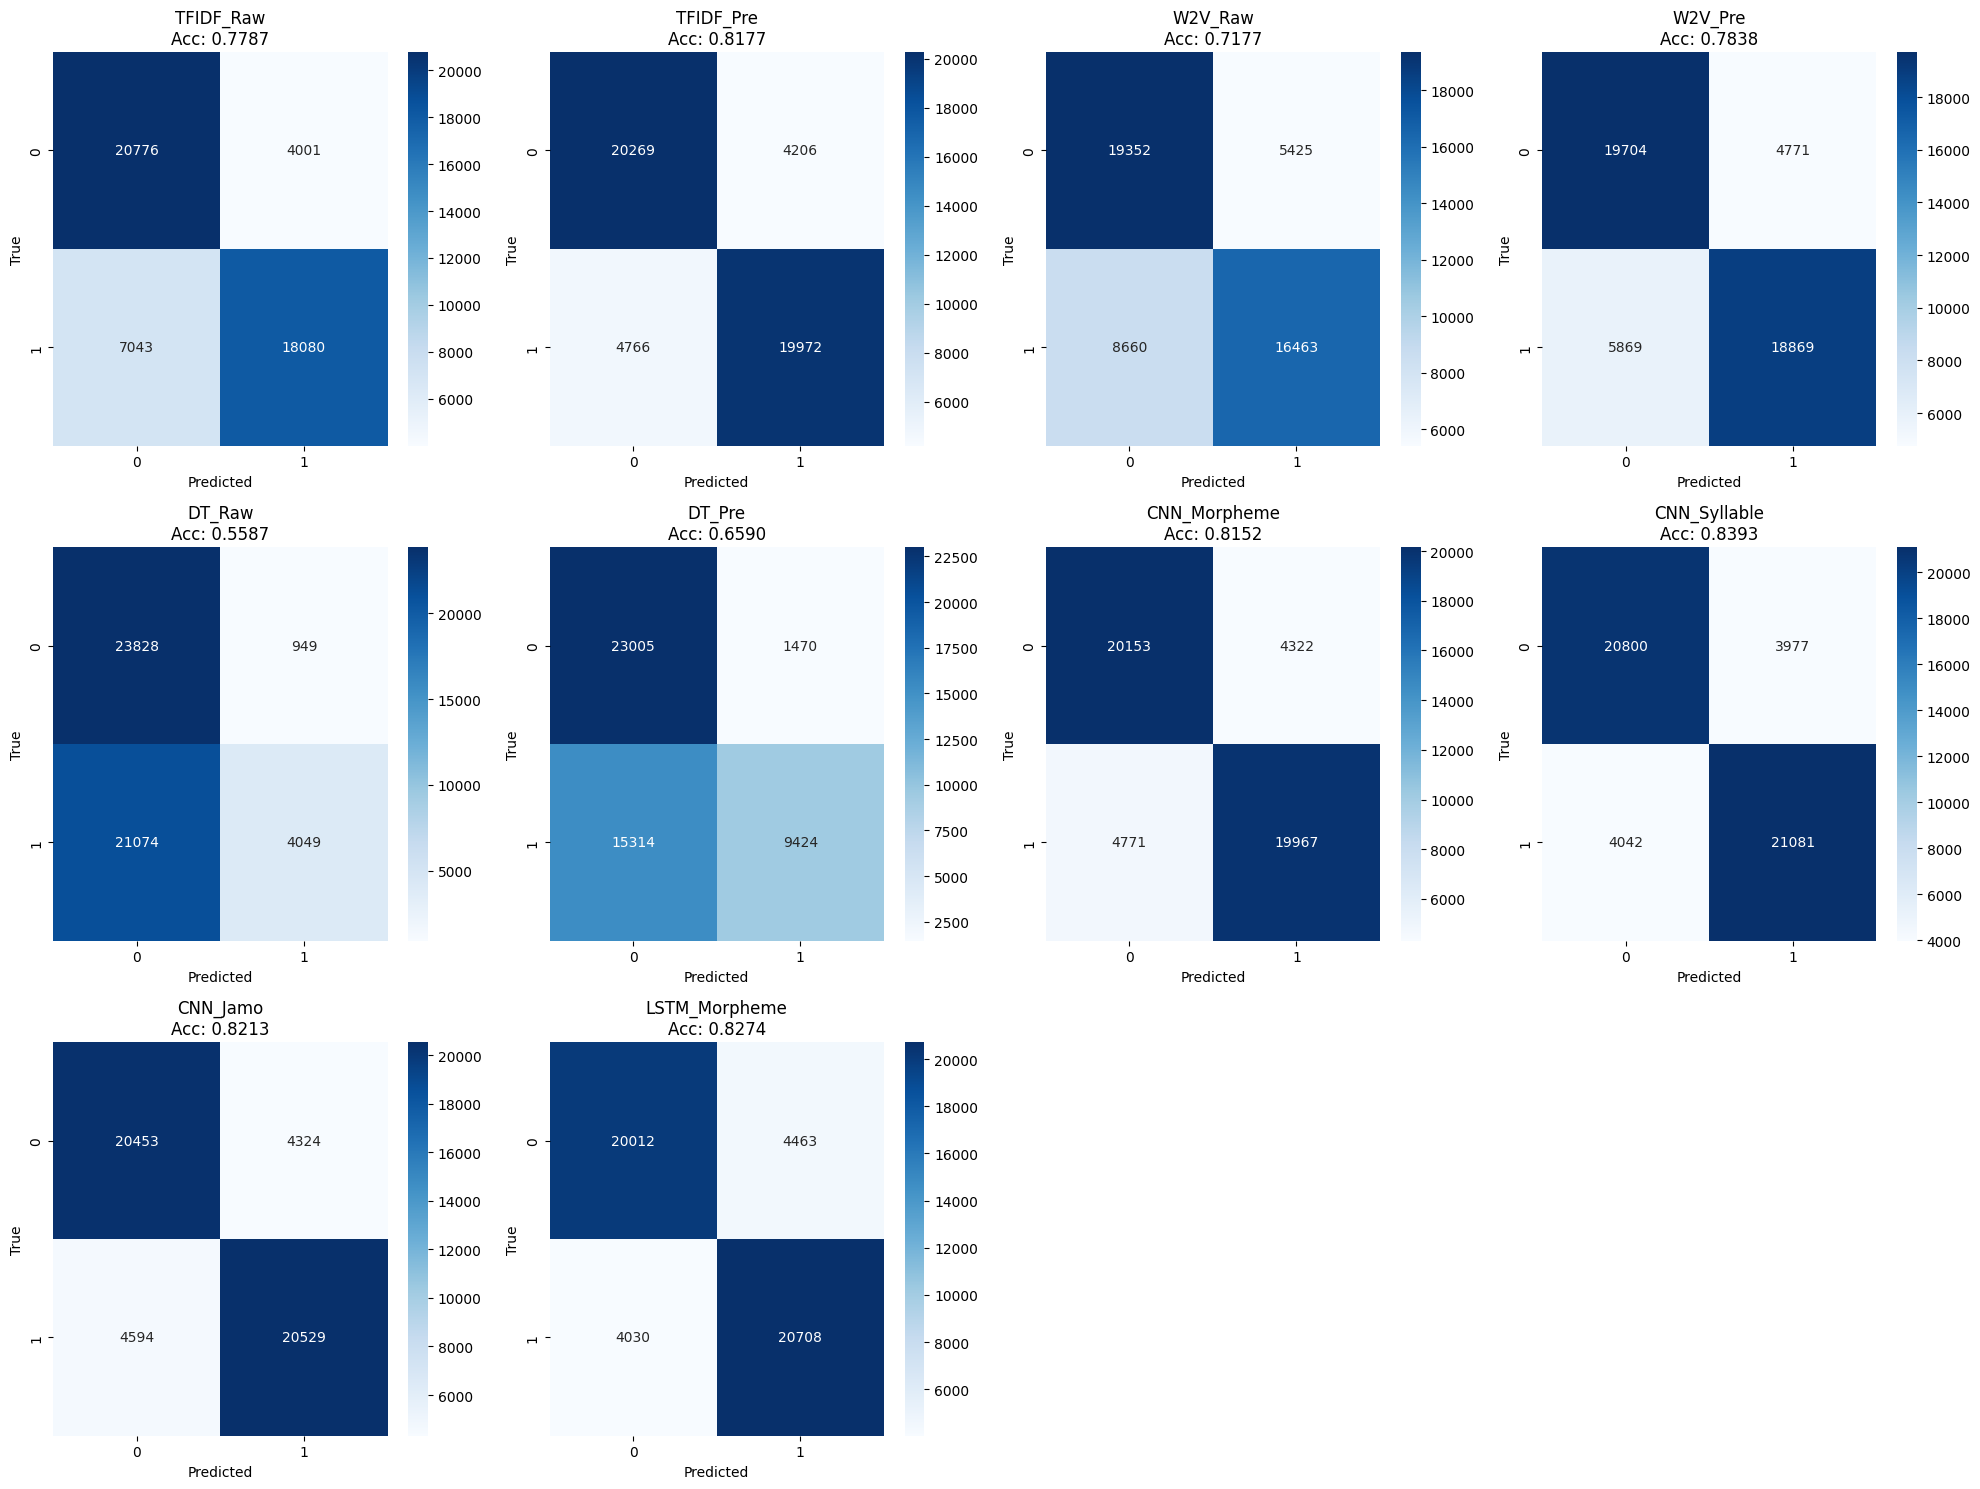

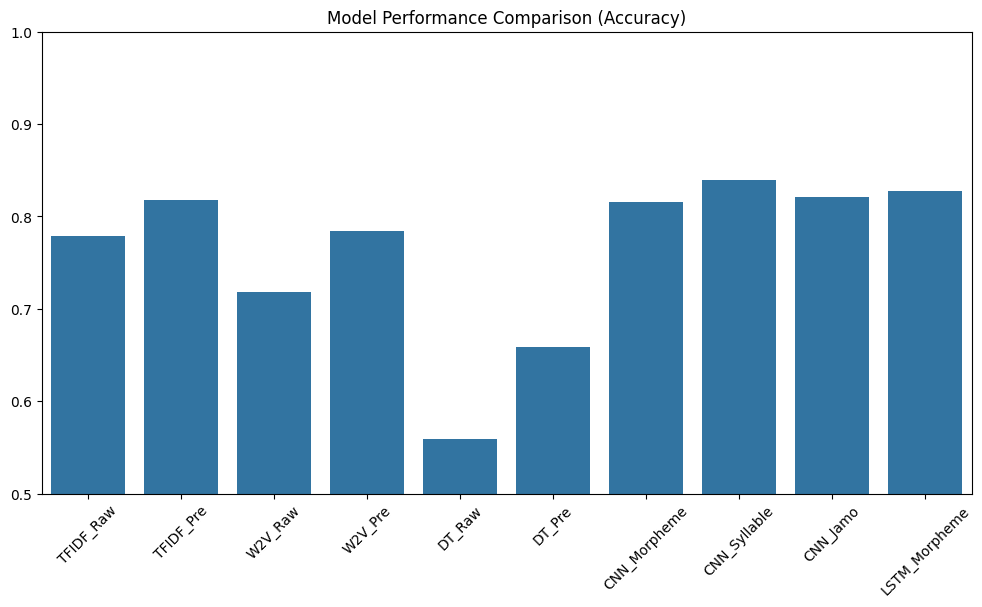


=== Final Accuracy Report ===
CNN_Syllable: 0.8393
LSTM_Morpheme: 0.8274
CNN_Jamo: 0.8213
TFIDF_Pre: 0.8177
CNN_Morpheme: 0.8152
W2V_Pre: 0.7838
TFIDF_Raw: 0.7787
W2V_Raw: 0.7177
DT_Pre: 0.6590
DT_Raw: 0.5587


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import os

model_names = [
    "TFIDF_Raw", "TFIDF_Pre", "W2V_Raw", "W2V_Pre", "DT_Raw", "DT_Pre",
    "CNN_Morpheme", "CNN_Syllable", "CNN_Jamo", "LSTM_Morpheme"
]

results = {}

# 모델 이름에 따라 올바른 정답 라벨(y_true)을 가져오는 함수
def get_y_true(name):
    if "Pre" in name or "Morpheme" in name:
        return test_morphs['labels']  # 형태소 분석 데이터 (개수가 더 적음)
    elif "Jamo" in name:
        return test_jamo['labels']    # 자소 단위 데이터
    else:
        return test_raw['labels']     # Raw 데이터 (Syllable 포함)

plt.figure(figsize=(20, 15))

for i, name in enumerate(model_names):
    fname = f'prediction_{name}.txt'
    if not os.path.exists(fname):
        print(f"File not found: {fname}")
        continue

    # 예측 결과 로드
    with open(fname, 'r') as f:
        preds = [int(float(line.strip())) for line in f]

    # [수정 적용] 해당 모델에 맞는 정답 라벨 가져오기
    y_true = get_y_true(name)

    # 만약 예측 파일과 정답 라벨의 길이가 다르면 경고 출력 후 건너뛰기 (안전장치)
    if len(preds) != len(y_true):
        print(f"[Warning] Length mismatch for {name}: Preds={len(preds)}, True={len(y_true)}")
        continue

    acc = accuracy_score(y_true, preds)
    results[name] = acc

    # 혼동 행렬 시각화
    cm = confusion_matrix(y_true, preds)
    plt.subplot(3, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name}\nAcc: {acc:.4f}")
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# 최종 성능 비교 그래프
plt.figure(figsize=(12, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.xticks(rotation=45)
plt.title("Model Performance Comparison (Accuracy)")
plt.ylim(0.5, 1.0)

plt.savefig('model_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 텍스트로 결과 출력
print("\n=== Final Accuracy Report ===")
for name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {acc:.4f}")

In [ ]:
"""
=== Final Accuracy Report ===
CNN_Syllable: 0.8393
LSTM_Morpheme: 0.8274
CNN_Jamo: 0.8213
TFIDF_Pre: 0.8177
CNN_Morpheme: 0.8152
W2V_Pre: 0.7838
TFIDF_Raw: 0.7787
W2V_Raw: 0.7177
DT_Pre: 0.6590
DT_Raw: 0.5587
"""